In [78]:
from numba import jit, njit
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import kwant.kpm


import scipy

import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

from scipy.ndimage import gaussian_filter


import cmath

from qutip import *
from joblib import Parallel, delayed


In [79]:
def corr_dis(L, W, a, xic):
    Nx = int(L/a)
    Ny = int(W/a)
    Vxy = np.random.normal(0, 1., size=(Ny, Nx))/(a) + 1j*0.0
    
    kkVxy = np.fft.fft2(Vxy)
    kx = 2*np.pi * np.fft.fftfreq(kkVxy.shape[1],d=a)
    ky = 2*np.pi * np.fft.fftfreq(kkVxy.shape[0],d=a)
    kx, ky = np.meshgrid(kx,ky)
    
    kVxy = np.multiply(kkVxy, np.exp( - .125 * xic**2. * (kx**2.+ky**2.)  ) ) * xic/np.sqrt(2.)
    
    Vxy = np.fft.ifft2(kVxy)
    Vxy = Vxy - np.sum(Vxy)/(1.*Nx*Ny)

    return Vxy

In [80]:
def v_img_singleside(W, N, min_l):
    arr_x = np.linspace(min_l, W+min_l, N)
    arr_V = - 1./(np.abs( arr_x ))
    return arr_V


def v_img(W, N, min_l):
    arr_V = []
    arr_x = np.linspace(-W/2, W/2, N)
    d = 1000*W + 2*min_l
    for x in arr_x:
        V = 0
        nf = 50000
        n_Z = np.linspace( -nf, nf, 2*nf+1)
        for n in n_Z:
            if n != 0:
                V += ( 1./(2*np.abs(n)) - 1./(2.*np.abs(n+500*(x)/d )) )
        if x < 0:
            arr_V.append(V)
        else:
            arr_V.append(V)
    return np.asarray(arr_V)/d*1000


def v_expcutoff_img_singleside(W, N, min_l, xiV):
    arr_x = np.linspace(min_l, W+min_l, N)
    arr_V = - 1./(np.abs( arr_x ))*np.exp( -(arr_x-min_l)**2/(2*xiV**2) )
    #arr_V = - 1./(np.abs( arr_x )) /( np.exp( (arr_x-min_l - xiV)/(.01*xiV) ) + 1 )
    return arr_V

In [81]:
def dos_fun(E_imgxx, E_dis, Vdis, Vimg, t, alpha, omB, Zeeman ):
    def dos_onsite(site):
            xi, yi = site.pos
            om0 = 4 * t * sigma_0  # Original onsite energy
            omRan = E_dis * Vdis[int(yi)][int(xi)] * sigma_0  # Disorder
            omImg = E_imgxx * Vimg[int(yi)] * sigma_0  # Image charge

            H_Zeeman = Zeeman / 2 * sigma_z  # Zeeman term (splits spin up/down)

            return om0 + omRan + omImg + H_Zeeman  # Return as a 2x2 matrix
    def dos_hopping(site_i, site_j):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        return - t*np.exp(-1j * 2*np.pi * alpha * (xi - xj) * (yi + yj)/2.)* sigma_0
    sys_nolead = kwant.Builder()
    sys_nolead[(lat(x, y) for x in range(L) for y in range(W))] = dos_onsite
    sys_nolead[lat.neighbors()] = dos_hopping
    sys_nolead = sys_nolead.finalized()

    #dos = kwant.kpm.SpectralDensity(sys_nolead, num_vectors=80, energy_resolution=omB/80 )
    dos = kwant.kpm.SpectralDensity(sys_nolead, energy_resolution = E_dis/2. )
    
    return dos

@njit
def filling_fun_a(arr_mu, dos_energies, dos_densities, T, W, L, alpha):
    number_e = np.zeros( len(arr_mu) )
    N_dos = len(dos_energies)
    for ne, E in enumerate(arr_mu):
        number_e[ne]= np.sum( np.divide( dos_densities ,  (np.exp( ( dos_energies - E)/T )+1)  ) )/(1.*N_dos)
    
    return number_e/((W-1)*(L-1)*alpha)

@njit
def filling_fun(arr_mu, dos_energies, dos_densities, T, W, L, alpha):
    number_e = np.zeros( len(arr_mu) )
    N_dos = len(dos_energies)
    for ne, E in enumerate(arr_mu):
        for ndos in range(1,len(dos_densities)):
            dE = (dos_energies[ndos]-dos_energies[ndos-1])
            number_e[ne] += dE * dos_densities[ndos-1] / (np.exp( ( dos_energies[ndos-1] - E)/T )+1) 
    
    return number_e/((W-1)*(L-1)*alpha)

@njit
def filling_fun_0T(arr_mu, dos_energies, dos_densities, W, L, alpha):
    number_e = np.zeros( len(arr_mu) )
    N_dos = len(dos_energies)
    for ne, E in enumerate(arr_mu):
        indx_fermi = np.argmin(np.abs(E-dos_energies))
        dos_F = dos_densities[0:indx_fermi]
        for ndos in range(1,len(dos_F)):
            number_e[ne] += dos_densities[ndos-1]*(dos_energies[ndos]-dos_energies[ndos-1])
    
    return number_e/((W-1)*(L-1)*alpha)

@njit
def fermi_f(T, E, dE):
    if np.abs(E / T) < 100.0:
        if dE / T < 1.0:
            dF = - np.exp(E / T) / (np.exp(E / T) + 1.0) ** 2.0 / T * dE
        else:
            dF = 1.0
    else:
        dF = 0.0
    return dF

@njit
def finite_temp(T, G, energies):
    W = np.zeros( len(G) )
    num_points = len(G)
    
    for n in range(num_points):
        weighted_sum = 0.0
        norm_factor = 0.0
        for i in range(1,num_points):
            dE = np.abs(energies[i] - energies[i - 1])
            E = energies[i-1] - energies[n]
            dF = 0
            if np.abs(E / T) < 200.0:
                dF = - np.exp(E / T) / (np.exp(E / T) + 1.0) ** 2.0 / T * dE
            else:
                dF = 0.0
            norm_factor += dF
            weighted_sum += G[i-1] * dF
        W[n] = weighted_sum / norm_factor if norm_factor != 0 else 0.0
    
    return W

In [82]:
# Energy-Length-Magnetic scale (arbitrary) just to have a dimensional reference for the parameters
#a=0.6 # real lattice spacing in GaAs, in nm
#BandW0 = 40   #total bandwidth in meV
#l0 = np.sqrt(568/BandW0*8.) * 10**(-3.) # effective lattice spacing sqrt( \hbar^2/(2m*)/(\hbar J)) here I took \hbar^2/(2m*) = 568 nm^2 meV (GaAs) and \hbar J = BW/8 in micron!
#B0 = 4.14*10**3. / (l0 * 10**3.)**2. #in T, as 2\pi \hbar/e 1/a^2


lat = kwant.lattice.square(a=1, norbs=2)
Ncore = 5       #number of cores used in the calculation
iter_dis = 1
t = 1   # hopping rate for kwant
W = 120  # spatial width of the system ( Nx )
L = 80  # spatial length of the system ( Ny )
# Define Pauli matrices
sigma_0 = np.array([[1, 0], [0, 1]])  # Identity (spin-independent)
sigma_x = np.array([[0, 1], [1, 0]])  # Pauli X
sigma_y = np.array([[0, -1j], [1j, 0]])  # Pauli Y
sigma_z = np.array([[1, 0], [0, -1]])  # Zeeman term

alpha0 = .005
iter_alpha = 200
dalpha = .008/iter_alpha
arr_alpha = np.linspace(alpha0, alpha0+dalpha*iter_alpha, iter_alpha)

Nelect = 5*alpha0*(W-1)*(L-1)

lB0 = 1./np.sqrt(2*np.pi*alpha0)
omB0 = 4*np.pi*alpha0

T = omB0/50

xic = lB0 * .5      # Correlation length and definition of disorder-potential array
Vdis = corr_dis(int(L), int(W), 1, xic)
plate_distance = 10*lB0      #edge-plate distance
Vimg = v_img_singleside(W, int(W), plate_distance)   # normalized image potential single plate
V_img_min = np.amin(Vimg)
Vimg = Vimg - V_img_min - lB0/plate_distance**2 
E_img = omB0*lB0 * ( (plate_distance/lB0)**2 )/2. * 1         # Image charge amplitude in Zeeman
E_dis = omB0 * .025                   # disorder amplitude in cyclotrons


G0 = np.zeros(iter_alpha)
GIMG = np.zeros(iter_alpha)

def onsite(site, params):
    xi, yi = site.pos

    om0 = 4 * t * sigma_0  # Original onsite energy
    omRan = params.E_dis * params.V[int(yi)][int(xi)] * sigma_0  # Disorder
    omImg = params.E_img * Vimg[int(yi)] * sigma_0  # Image charge

    H_Zeeman = params.Zeeman / 2 * sigma_z  # Zeeman term (splits spin up/down)

    return om0 + omRan + omImg + H_Zeeman  # Return as a 2x2 matrix

def hopping(site_i, site_j, params):
    xi, yi = site_i.pos
    xj, yj = site_j.pos

    phase = -1j * 2 * np.pi * params.alpha * (xi - xj) * (yi + yj) / 2.
    
    return -t * np.exp(phase) * sigma_0  # Spin-preserving hopping

def onsite_lead(site, params):
    return 4 * t * sigma_0 + (params.Zeeman / 2) * sigma_z  # Zeeman in leads

def hopping_lead(site_i, site_j, params):
    return -t * sigma_0  # Spin-independent hopping

sys = kwant.Builder()
sys[(lat(x, y) for x in range(L) for y in range(W))] = onsite
sys[lat.neighbors()] = hopping

sym_left_lead = kwant.TranslationalSymmetry((-1, 0))
left_lead = kwant.Builder(sym_left_lead)
left_lead[(lat(0, y) for y in range(W))] = onsite_lead
left_lead[lat.neighbors()] = hopping_lead
sys.attach_lead(left_lead)
sys.attach_lead(left_lead.reversed())

sys = sys.finalized()

EFimg = omB0 * ( .5 + 5.1 )
EF0 = omB0 * ( .5 + 5 )

In [83]:
BandW_eff = 140   #total bandwidth in meV
l0_eff = np.sqrt(568/BandW_eff*8.) * 10**(-3.) # effective lattice spacing sqrt( \hbar^2/(2m*)/(\hbar J)) here I took \hbar^2/(2m*) = 568 nm^2 meV (GaAs) and \hbar J = BW/8 in micron!
B0_eff = 4.14*10**3. / (l0_eff * 10**3.)**2. #in T, as 2\pi \hbar/e 1/a^2



print(E_img*BandW_eff/8*l0_eff, omB0*BandW_eff/8)

1.7671284892922345 1.0995574287564276


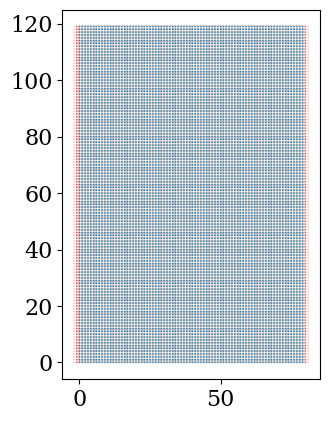

Text(0, 0.5, '$U_{\\rm img}/(\\hbar\\omega_B)$')

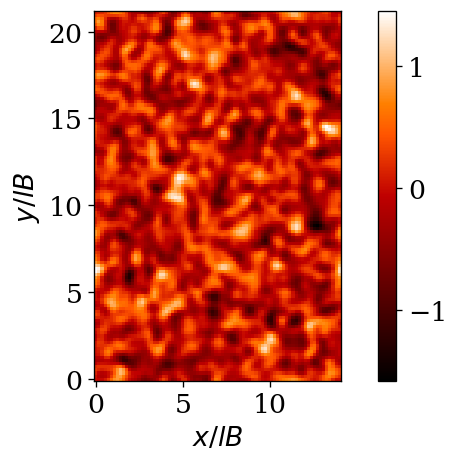

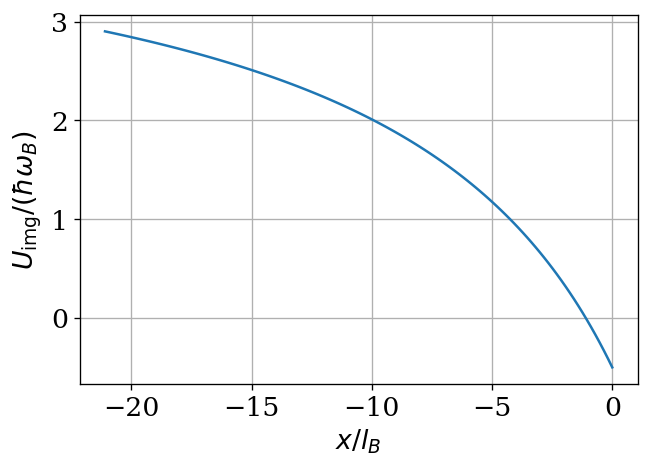

In [84]:
#plot some structural kwant stuff
kwant.plot(sys);

xvec = np.linspace(0, L-1, int(L) )
yvec = np.linspace(0, W-1, int(W) )
X, Y = np.meshgrid(xvec, yvec)

fig_W, ax_W = plt.subplots(dpi=120, figsize=(8, 4))
vmin = 0.
vmax = 1.000
Wmap_plot = ax_W.pcolormesh(X/lB0, Y/lB0, (Vdis.real), cmap='gist_heat', alpha=1)  #, vmin=vmin, vmax=vmax)
fig_W.colorbar(Wmap_plot)
ax_W.set_xlabel(r'$x/lB$')
ax_W.set_ylabel(r'$y/lB$')
ax_W.set_aspect('equal')


fig_Img, ax_Img = plt.subplots(dpi=120, figsize=(6, 4))
ax_Img.plot( -yvec/lB0, E_img/omB0*(Vimg) )
ax_Img.grid()

ax_Img.set_xlabel(r'$x/l_B$')
ax_Img.set_ylabel(r'$U_{\rm img}/(\hbar\omega_B)$')
#ax_Img.set_aspect('equal')



In [85]:
NET = 51

def G_conductance(na, arr_alpha):
    alpha = arr_alpha[na]
    lB = 1./np.sqrt(2*np.pi*alpha)
    omB = 4*np.pi*alpha

    Zeeman = omB/3.5

    params =SimpleNamespace( alpha=alpha, E_dis=E_dis, E_img=0, V=Vdis, Vimg=Vimg, Zeeman=Zeeman )
    params_img = SimpleNamespace( alpha=alpha, E_dis=E_dis, E_img=E_img, V=Vdis, Vimg=Vimg, Zeeman=Zeeman )
    
    if NET > 1:
        dT = 20.*T/NET
        G0_EF_v = np.zeros(NET)
        GIMG_EF_v = np.zeros(NET)
        arr_en0 = np.zeros(NET)
        arr_enimg = np.zeros(NET)
        for nE in range(NET):
            
            ET0 = EF0 - 10.*T + dT*nE
            arr_en0[nE] = ET0
            ETimg = EFimg - 10.*T + dT*nE
            arr_enimg[nE] = ETimg
            
            smat = kwant.smatrix(sys, energy=ET0, args=[params])
            smat_img = kwant.smatrix(sys, energy=ETimg, args=[params_img])
            G0_EF = smat.transmission(0, 1)
            GIMG_EF = smat_img.transmission(0, 1)
            G0_EF_v[nE] = G0_EF
            GIMG_EF_v[nE] = GIMG_EF
            
        G0_EF = finite_temp(T, G0_EF_v, arr_en0)
        GIMG_EF = finite_temp(T, GIMG_EF_v, arr_enimg)
    else:
        smat = kwant.smatrix(sys, energy=EF0, args=[params])
        smat_img = kwant.smatrix(sys, energy=EFimg, args=[params_img])
        G0_EF = smat.transmission(0, 1)
        GIMG_EF = smat_img.transmission(0, 1)

    return G0_EF, GIMG_EF, EF0, EFimg

# Define a function to compute conductance for a single iteration
def compute_conductance(na):
    return G_conductance( na, arr_alpha  )

# Use joblib to parallelize the loop
results = Parallel(n_jobs=Ncore)(
    delayed(compute_conductance)(na) for na in range(iter_alpha)
)

G0 = []
GIMG = []
arr_E0 = []
arr_Eimg = []
# Aggregate the results
for sG0, sGIMG, EF0, EFimg in results:
    G0.append( sG0 )
    GIMG.append( sGIMG )
    arr_E0.append( EF0 )
    arr_Eimg.append( EFimg )
G0 = np.asarray(G0)
GIMG = np.asarray(GIMG)
arr_E0 = np.asarray(arr_E0)
arr_Eimg = np.asarray(arr_Eimg)

/opt/anaconda3/lib/python3.12/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "
/opt/anaconda3/lib/python3.12/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "
/opt/anaconda3/lib/python3.12/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "
/opt/anaconda3/lib/python3.12/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "
/opt

In [86]:
G0rr = G0
GIMGrr = GIMG

In [87]:
if NET>1:
    G0 = G0rr[:,int((NET-1)/2)]
    GIMG = GIMGrr[:,int((NET-1)/2)]

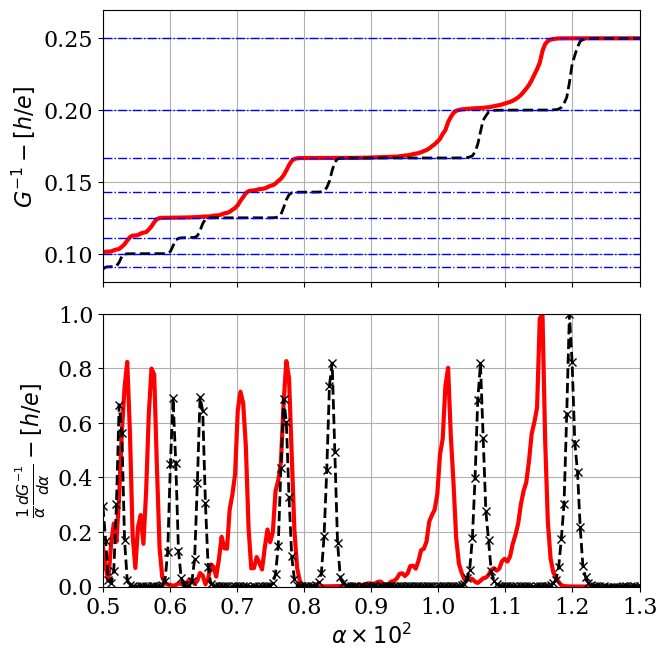

In [95]:
G0_g = gaussian_filter(G0, sigma=.1)
GIMG_g = gaussian_filter(GIMG, sigma=.1)
#G0_g = G0
#GIMG_g = GIMG

dG0_dalpha = np.gradient(1/G0_g, arr_alpha)
dGIMG_dalpha = np.gradient(1/GIMG_g, arr_alpha)

RIMG = 1/GIMG_g
R0 = 1/G0_g

arr_alpha_norm = arr_alpha*1e2
x0 = np.amin(arr_alpha_norm)
x1 = np.amax(arr_alpha_norm)

# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
# First subplot
ax1.plot( arr_alpha_norm, RIMG, color='red', linestyle='-', linewidth=3)
ax1.plot( arr_alpha_norm, R0, color='black', linestyle='--', linewidth=2)
#for nnu in range(10):
    #ax1.axvline(  1.05*Nelect_0/ ((1+nnu)*(W-1)*(L-1)) , color='black', linewidth=2)  
    #ax1.axvline(  Nelect_img/ ((1+nnu)*(W-1)*(L-1)) , color='red', linewidth=2)
for mm in range(1,12):
      ax1.axhline(  1/mm , linewidth=1, color='blue', linestyle='-.')

der_img = np.abs(dGIMG_dalpha)/arr_alpha
der_0 = np.abs(dG0_dalpha)/arr_alpha

ax2.plot( arr_alpha_norm, der_img/np.amax(der_img), color='red', linestyle='-', linewidth=3)
ax2.plot( arr_alpha_norm,der_0/np.amax(der_0), color='black', marker='x', linestyle='--', linewidth=2)
#for mm in range(1,10):
#      ax2.axvline(  Nelect_0/(mm*(W-3)*(L-3))*1e2 , linewidth=1, color='blue', linestyle='-.')
      
ax1.set_ylim((.08, .27))
ax1.set_xlim( (x0, x1) )
ax2.set_ylim((0, 1.))  
ax2.set_xlim( (x0, x1) )

ax1.set_xticklabels([])
#ax1.set_xlabel(r"$\alpha$", fontdict=font)
ax1.set_ylabel(r"$G^{-1} - [h/e]$", fontdict=font)
ax2.set_xlabel(r"$\alpha \times 10^{2}$", fontdict=font)
ax2.set_ylabel(r"$\frac{1}{\alpha}\frac{dG^{-1}}{d\alpha} - [h/e]$", fontdict=font)

#ax2.set_yscale('log')  # Set log scale on y-axis
ax1.grid()
ax2.grid()
plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 170 / 25.4)

plt.show()

In [91]:
# save platos in a file
import pandas as pd
nG = 0
# Parameters
params = {
    "t": t,
    "W": W,
    "L": L,
    "xic": xic,
    "plate_distance": plate_distance,
    "E_dis": E_dis,
    "E_img": E_img,
    "omB0": omB0,
    "EFimg": EFimg,
    "EF0": EF0,
    "T": T,
    "iter_dis": iter_dis,
    "Ncore": Ncore
}

# Create a DataFrame
data = pd.DataFrame({
    'alpha': arr_alpha,
    'G0': G0,
    'GIMG': GIMG
})

# Write parameters and data to a file
filename = 'G_%d.dat' % (nG)
with open(filename, 'w') as f:
    # Write parameters as comments
    for key, value in params.items():
        f.write(f"# {key} = {value}\n")
    # Write the data
    data.to_csv(f, sep=' ', index=False, header=True)